<h1>Tensor Network Quantum Circuits</h1>
In this notebook the pennylane tutorial about tensor network quantum circuits will be reimplemented and a study will be performed on a new dataset.(the multiclass handwritten numbers mnist)

<h3>Outline</h3>

*   Matrix product state (MPS): using simple ansatz
*   Matrix product state (MPS): using strongly entangling layers ansatz
*   Matrix product state (MPS): using simplified two design ansatz
*   Tree tensor network (TTN): using simple ansatz example 1(8 qubits)
*   Tree tensor network (TTN): using simple ansatz example 2(4 qubits)
*   Classifying the bars and stripes dataset
*   mnist dataset



<h3>Matrix product state (MPS): using simple ansatz</h3>

In [1]:
!pip install pennylane --upgrade

In [2]:
import pennylane as qml
from pennylane import numpy as np

In [3]:
def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

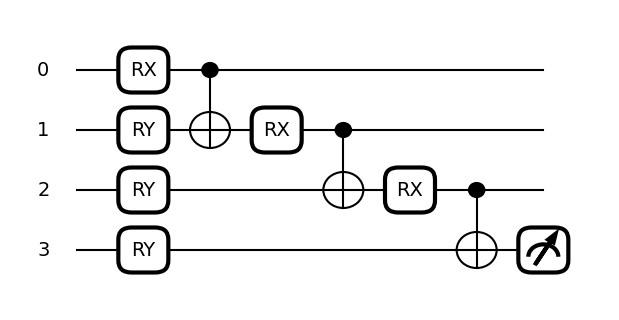

In [4]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev)
def circuit(template_weights):
    qml.MPS(
        wires=range(4),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))


np.random.seed(1)
weights = np.random.random(size=[3, 2])
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights)
fig.set_size_inches((6, 3))

<h3>Matrix product state (MPS): using strongly entangling layers ansatz</h3>

In [5]:
def deep_block(weights, wires):
    qml.StronglyEntanglingLayers(weights, wires)

In [6]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev)
def circuit(template_weights):
    qml.MPS(
        wires=range(4),
        n_block_wires=2,
        block=deep_block,
        n_params_block=3,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))

(2, 2, 3)


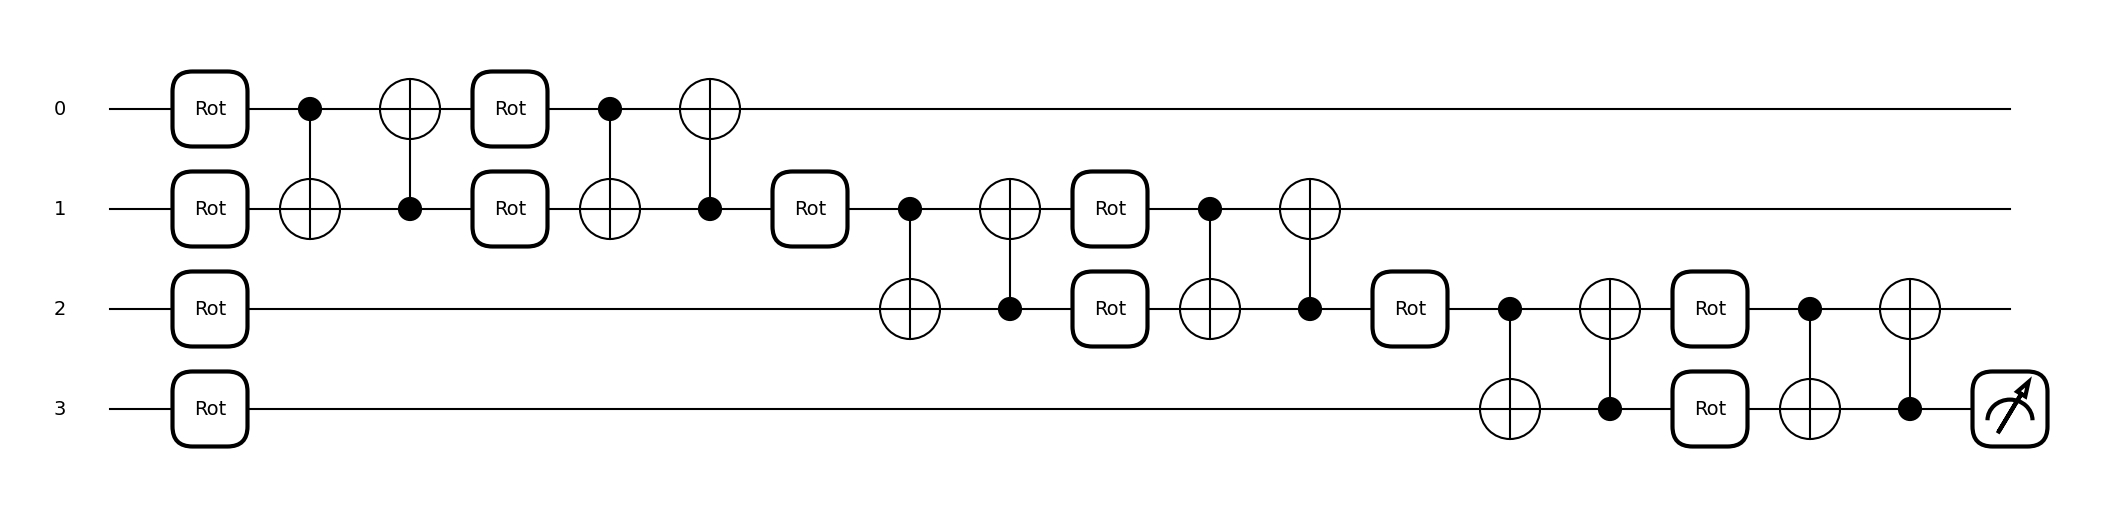

In [7]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=2)
print(shape)
template_weights = [np.random.random(size=shape)] * 3
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(template_weights)

<h3>Matrix product state (MPS): using simplified two design ansatz</h3>

In [8]:
def wide_block(weights, wires):
    qml.SimplifiedTwoDesign(initial_layer_weights=weights[0], weights=weights[1], wires=wires)

(4,)
(1, 3, 2)


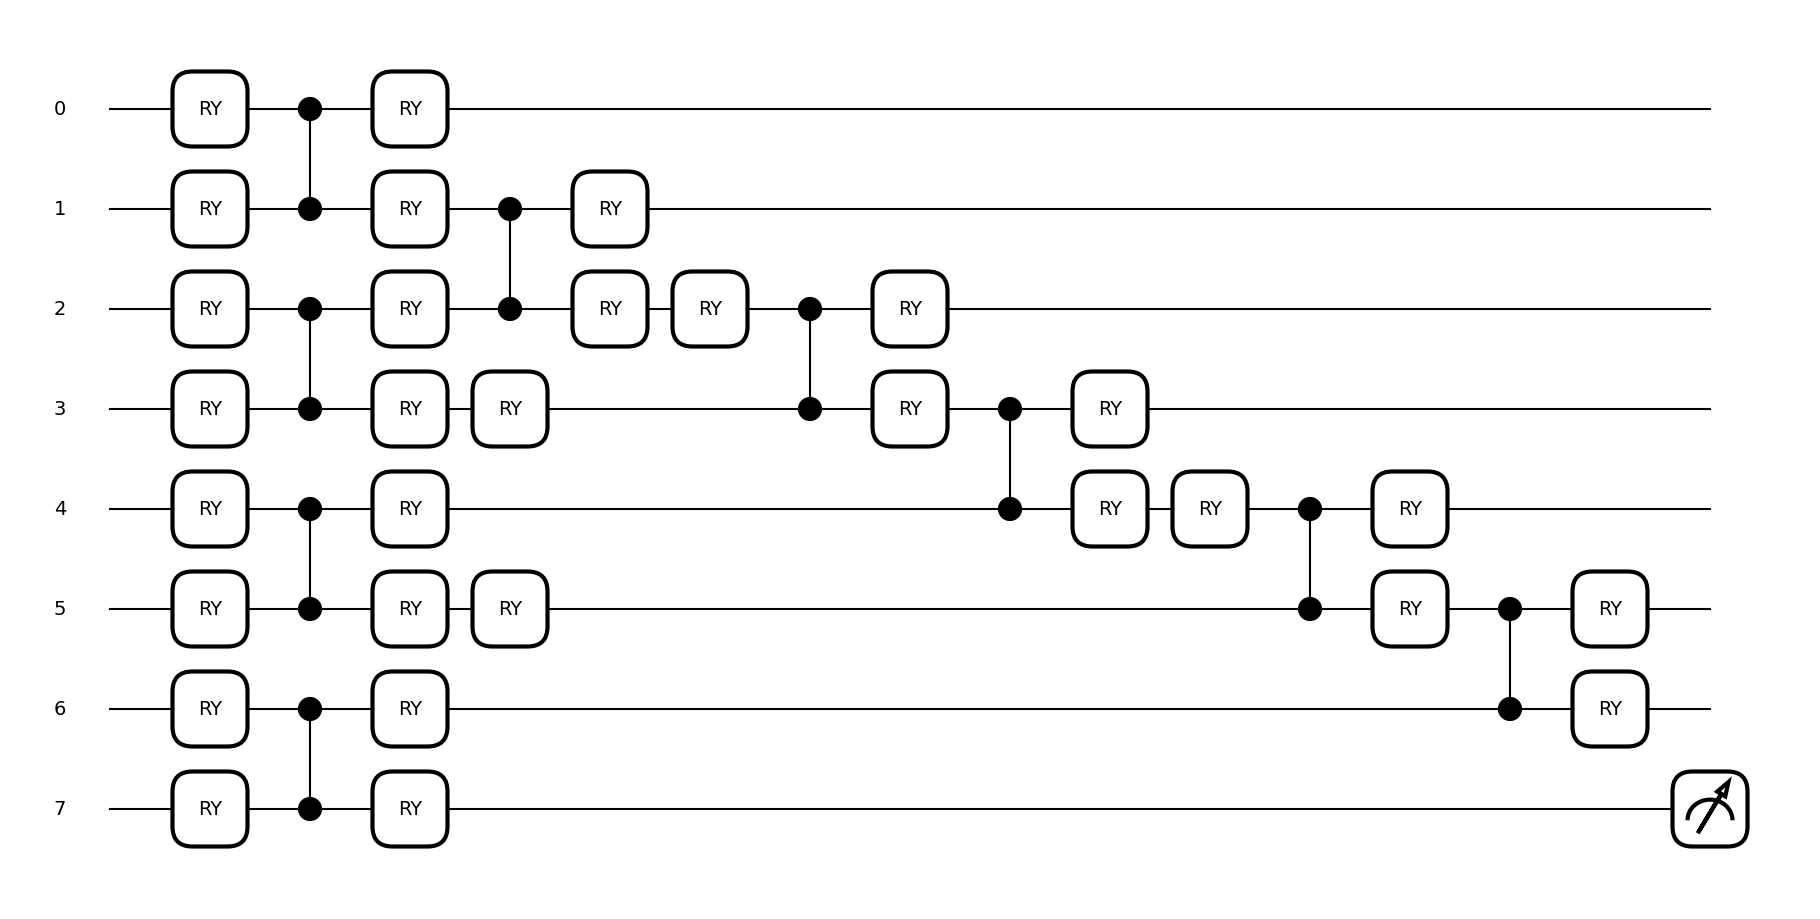

In [9]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(template_weights):
    qml.MPS(
        wires=range(8),
        n_block_wires=4,
        block=wide_block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=7))


shapes = qml.SimplifiedTwoDesign.shape(n_layers=1, n_wires=4)
for shape in shapes:
  print(shape)
weights = [np.random.random(size=shape)  for shape in shapes]
template_weights = [np.array(weights, dtype="object")]*3
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(template_weights)

<h3>Tree tensor network (TTN): using simple ansatz example 1(8 qubits)</h3>

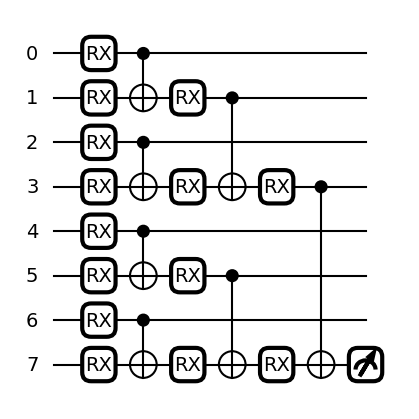

In [10]:
def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RX(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)


dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(template_weights):
    qml.TTN(
        wires=range(8),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=7))


weights = np.random.random(size=[7, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights)
fig.set_size_inches((4, 4))

<h3>Tree tensor network (TTN): using simple ansatz example 2(4 qubits)</h3>

In [11]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

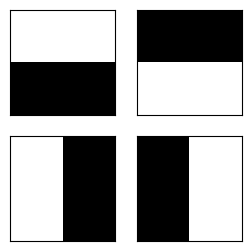

In [12]:
import matplotlib.pyplot as plt

BAS = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1]]
j = 1
plt.figure(figsize=[3, 3])
for i in BAS:
    plt.subplot(2, 2, j)
    j += 1
    plt.imshow(np.reshape(i, [2, 2]), cmap="gray")
    plt.xticks([])
    plt.yticks([])

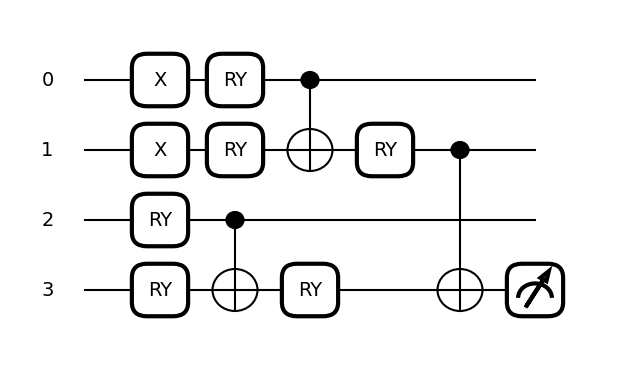

In [13]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.BasisStatePreparation(image, wires=range(4))
    qml.TTN(
        wires=range(4),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))

weights = np.random.random(size=[3, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

<h3>Classifying the bars and stripes dataset</h3>

In [14]:
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [15]:
params = np.random.random(size=[3, 2], requires_grad=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

for k in range(100):
    if k % 20 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: -0.004445754170192884
Step 20, cost: -0.12881287874931857
Step 40, cost: -3.999923506552082
Step 60, cost: -3.999999999999898
Step 80, cost: -4.0


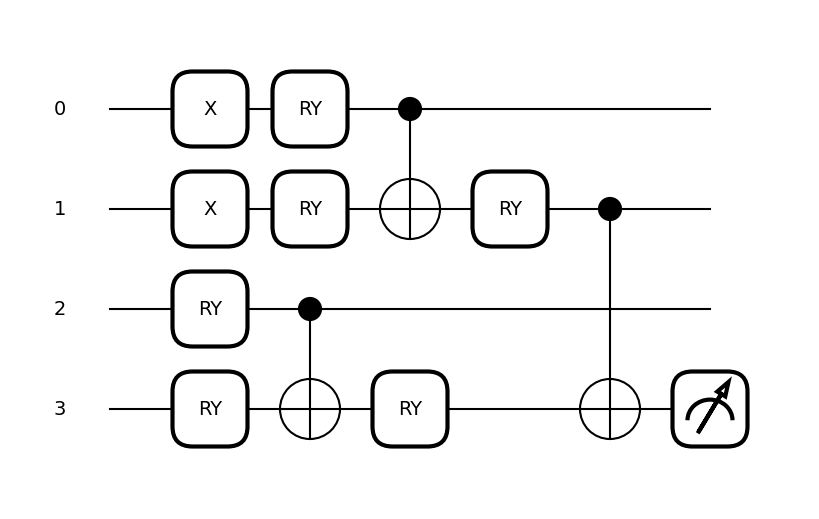

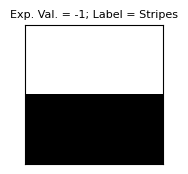

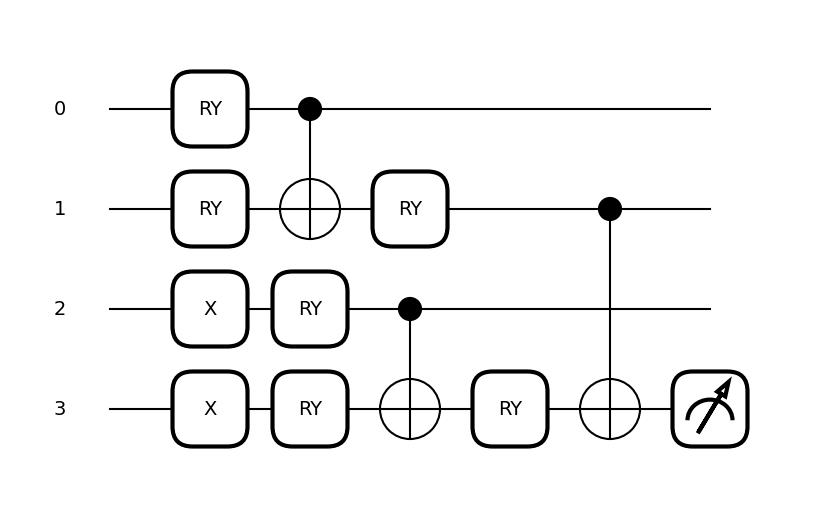

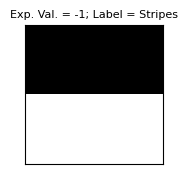

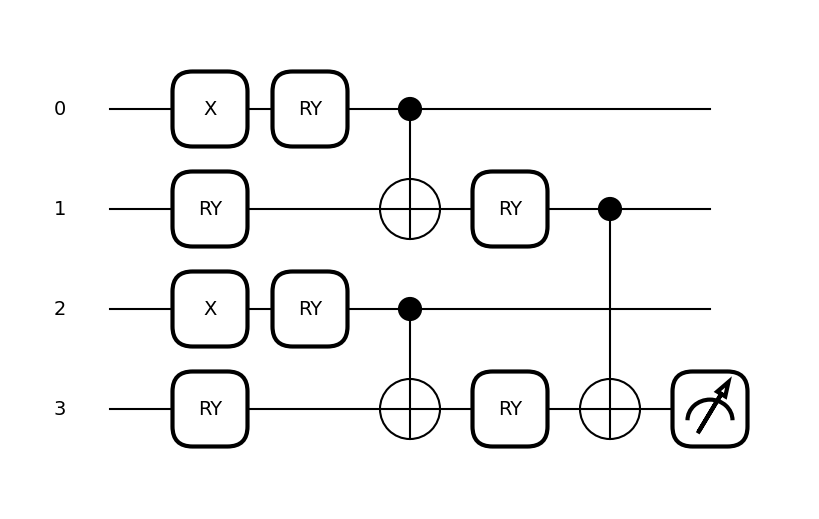

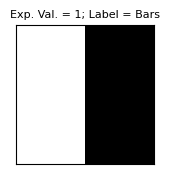

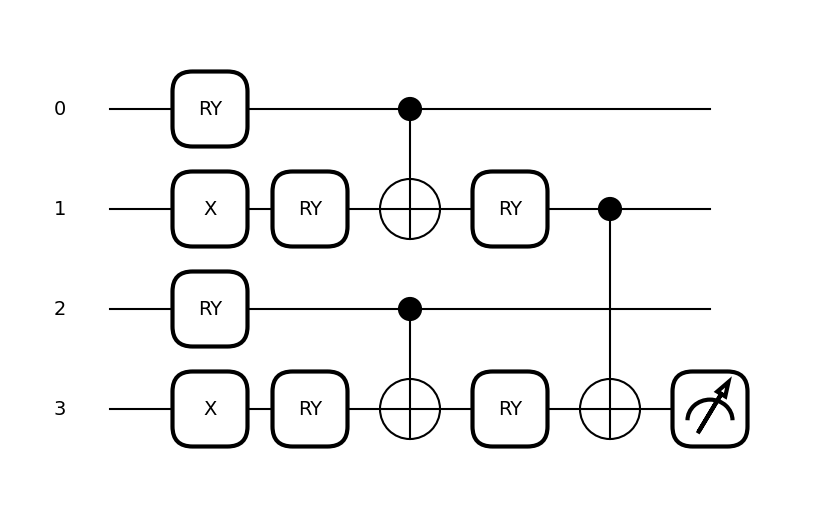

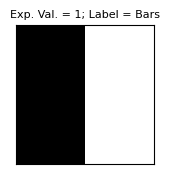

In [16]:
for image in BAS:
    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(image, params)
    plt.figure(figsize=[1.8, 1.8])
    plt.imshow(np.reshape(image, [2, 2]), cmap="gray")
    plt.title(
        f"Exp. Val. = {circuit(image,params):.0f};"
        + f" Label = {'Bars' if circuit(image,params)>0 else 'Stripes'}",
        fontsize=8,
    )
    plt.xticks([])
    plt.yticks([])

<h3>mnist dataset</h3>

In [17]:
!pip install keras

In [18]:
import keras

In [19]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [20]:
def fourByFour(ary):
  x = ary
  summing = 0
  all = []
  for i in range(28*28):
    if (i+1)%49 == 0:
      if summing <= 255*49/2:
        all.append(1)
      else:
        all.append(0)
      summing = 0
    else:
      summing += ary[i]
  return all

In [21]:
BAS = []
for image in train_images:
  BAS.append(fourByFour(image.reshape(28*28)))

In [22]:
BAS[6]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [23]:
BAS[4]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

In [25]:
for x in BAS:
  if len(x) !=16:
    print("not")

In [26]:
BAS[3]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

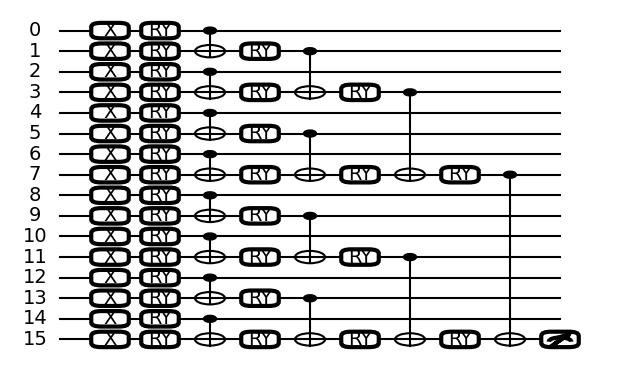

In [27]:
dev = qml.device("default.qubit", wires=16)


@qml.qnode(dev)
def circuit(image, template_weights):
    qml.BasisStatePreparation(image, wires=range(16))
    qml.TTN(
        wires=range(16),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=15))

weights = np.random.random(size=[15, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [28]:
len(BAS)

60000

In [29]:
BAS = BAS[0: 100]
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [30]:
params = np.random.random(size=[15, 2], requires_grad=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

for k in range(40):
    if k % 5 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: 0.12865982246519925
Step 5, cost: -0.24690321204814747
Step 10, cost: -0.8533656026046252
Step 15, cost: -1.6150569265455155
Step 20, cost: -1.9120238866882502
Step 25, cost: -1.9720737712350158
Step 30, cost: -1.9867357844669389
Step 35, cost: -1.991934435228376


In [ ]:
for image in BAS:
    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(image, params)
    plt.figure(figsize=[1.8, 1.8])
    plt.imshow(np.reshape(image, [4, 4]), cmap="gray")
    plt.title(
        f"Exp. Val. = {circuit(image,params):.0f};"
        + f" Label = {'Bars' if circuit(image,params)>0 else 'Stripes'}",
        fontsize=8,
    )
    plt.xticks([])
    plt.yticks([])